In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

model_path = "./final_absa_model"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


c:\Users\reidu\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The tokenizer you are loading from './final_absa_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

The tokenizer you are loading from './final_absa_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Model & tokenizer loaded.


Map: 100%|██████████| 6001/6001 [00:00<00:00, 18196.58 examples/s]


tokenized_datasets ready. Test size: 6001
Predictions computed.


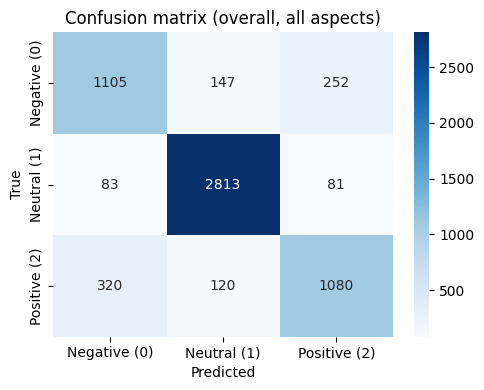

In [ ]:
import pandas as pd
import numpy as np
import random
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

ASPECTS = [
    "Cost of Living", "Healthcare", "Education", "Personal Security",
    "Employment", "Transportation", "Government", "Environment",
    "Social Equality", "Taxation"
]

model_path = "./final_absa_model"   # папка, которую ты сохранял trainer.save_model(...)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print("Model & tokenizer loaded.")

df = pd.read_json("synthetic_10000.jsonl", lines=True)
labels_expanded = df["labels"].apply(pd.Series)
df = pd.concat([df.drop(columns=["labels"]), labels_expanded], axis=1)

def transform_to_absa_format(original_df):
    rows = []
    for _, row in original_df.iterrows():
        tweet = row["tweet_text"]
        active, inactive = [], []
        for a in ASPECTS:
            if row[a] != 0:
                active.append(a)
            else:
                inactive.append(a)
        for a in active:
            s = row[a]
            label = 0 if s == -1 else 2
            rows.append({"text": tweet, "aspect": a, "label": label})
        k = len(active)
        if k > 0 and len(inactive) > 0:
            sampled = random.sample(inactive, k=min(k, len(inactive)))
            for a in sampled:
                rows.append({"text": tweet, "aspect": a, "label": 1})
    return pd.DataFrame(rows)

absa_df = transform_to_absa_format(df)
hf_dataset = Dataset.from_pandas(absa_df)
dataset_dict = hf_dataset.train_test_split(test_size=0.2, seed=42)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        examples["aspect"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
test_ds = tokenized_datasets["test"]

print("tokenized_datasets ready. Test size:", len(test_ds))

all_logits = []
all_labels = []
all_aspects = []

for ex in test_ds:
    inputs = {
        "input_ids": torch.tensor(ex["input_ids"]).unsqueeze(0).to(device),
        "attention_mask": torch.tensor(ex["attention_mask"]).unsqueeze(0).to(device),
    }
    with torch.no_grad():
        logits = model(**inputs).logits.cpu().numpy()[0]

    all_logits.append(logits)
    all_labels.append(ex["label"])
    all_aspects.append(ex["aspect"])

all_logits = np.vstack(all_logits)              
all_labels = np.array(all_labels)              
preds = all_logits.argmax(axis=-1)

print("Predictions computed.")

label_names = ["Negative (0)", "Neutral (1)", "Positive (2)"]
cm = confusion_matrix(all_labels, preds, labels=[0, 1, 2])

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix (overall, all aspects)")
plt.tight_layout()
plt.show()


Running final predictions on test set...



--- Detailed Classification Report ---
                   precision    recall  f1-score   support

     Negative (0)       0.73      0.73      0.73      1504
Not Mentioned (1)       0.91      0.94      0.93      2977
     Positive (2)       0.76      0.71      0.74      1520

         accuracy                           0.83      6001
        macro avg       0.80      0.80      0.80      6001
     weighted avg       0.83      0.83      0.83      6001



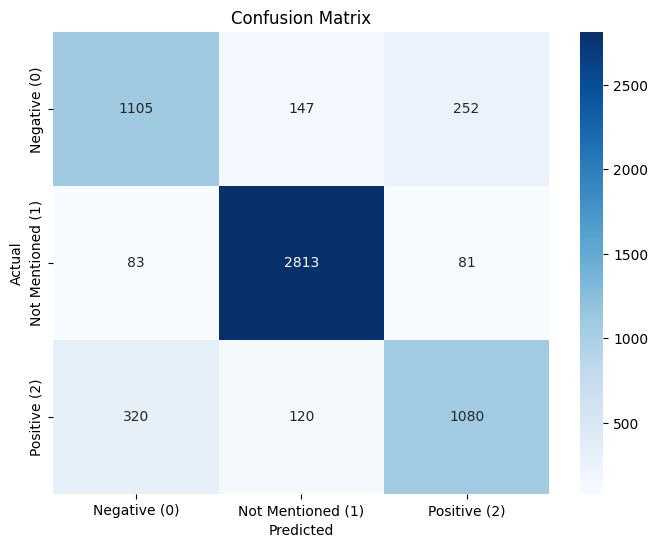

In [4]:
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

training_args = TrainingArguments(
    output_dir="./temp_results", 
    per_device_eval_batch_size=16, 
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args
)

print("Running final predictions on test set...")
predictions_output = trainer.predict(tokenized_datasets["test"])

preds = np.argmax(predictions_output.predictions, axis=-1)
labels = predictions_output.label_ids

target_names = ["Negative (0)", "Not Mentioned (1)", "Positive (2)"]

print("\n--- Detailed Classification Report ---")
print(classification_report(labels, preds, target_names=target_names))


cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
import torch

model.eval()
device = model.device

test_ds = tokenized_datasets["test"]

all_logits = []
all_labels = []
all_aspects = []

for i in range(len(test_ds)):
    item = test_ds[i]
    inputs = {
        "input_ids": torch.tensor(item["input_ids"]).unsqueeze(0).to(device),
        "attention_mask": torch.tensor(item["attention_mask"]).unsqueeze(0).to(device),
    }
    with torch.no_grad():
        logits = model(**inputs).logits.cpu().numpy()[0]

    all_logits.append(logits)
    all_labels.append(item["label"])
    all_aspects.append(item["aspect"])

all_logits = np.stack(all_logits)           
all_labels = np.array(all_labels)           
all_aspects = np.array(all_aspects)         
all_preds  = all_logits.argmax(axis=-1)     


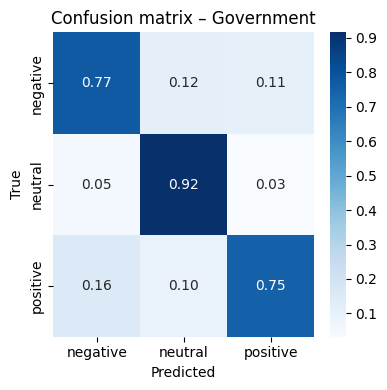

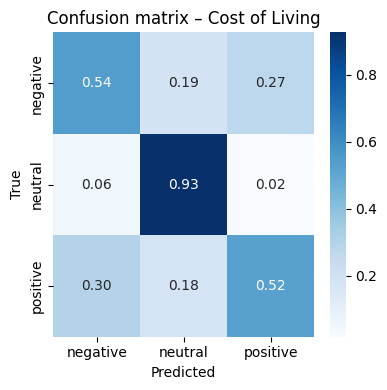

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_names = ["negative", "neutral", "positive"]

def plot_confusion_for_aspect(aspect_name):
    mask = (all_aspects == aspect_name)
    y_true = all_labels[mask]
    y_pred = all_preds[mask]

    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2], normalize="true")

    plt.figure(figsize=(4,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f",
        xticklabels=label_names,
        yticklabels=label_names,
        cmap="Blues",
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion matrix – {aspect_name}")
    plt.tight_layout()
    plt.show()

plot_confusion_for_aspect("Government")
plot_confusion_for_aspect("Cost of Living")


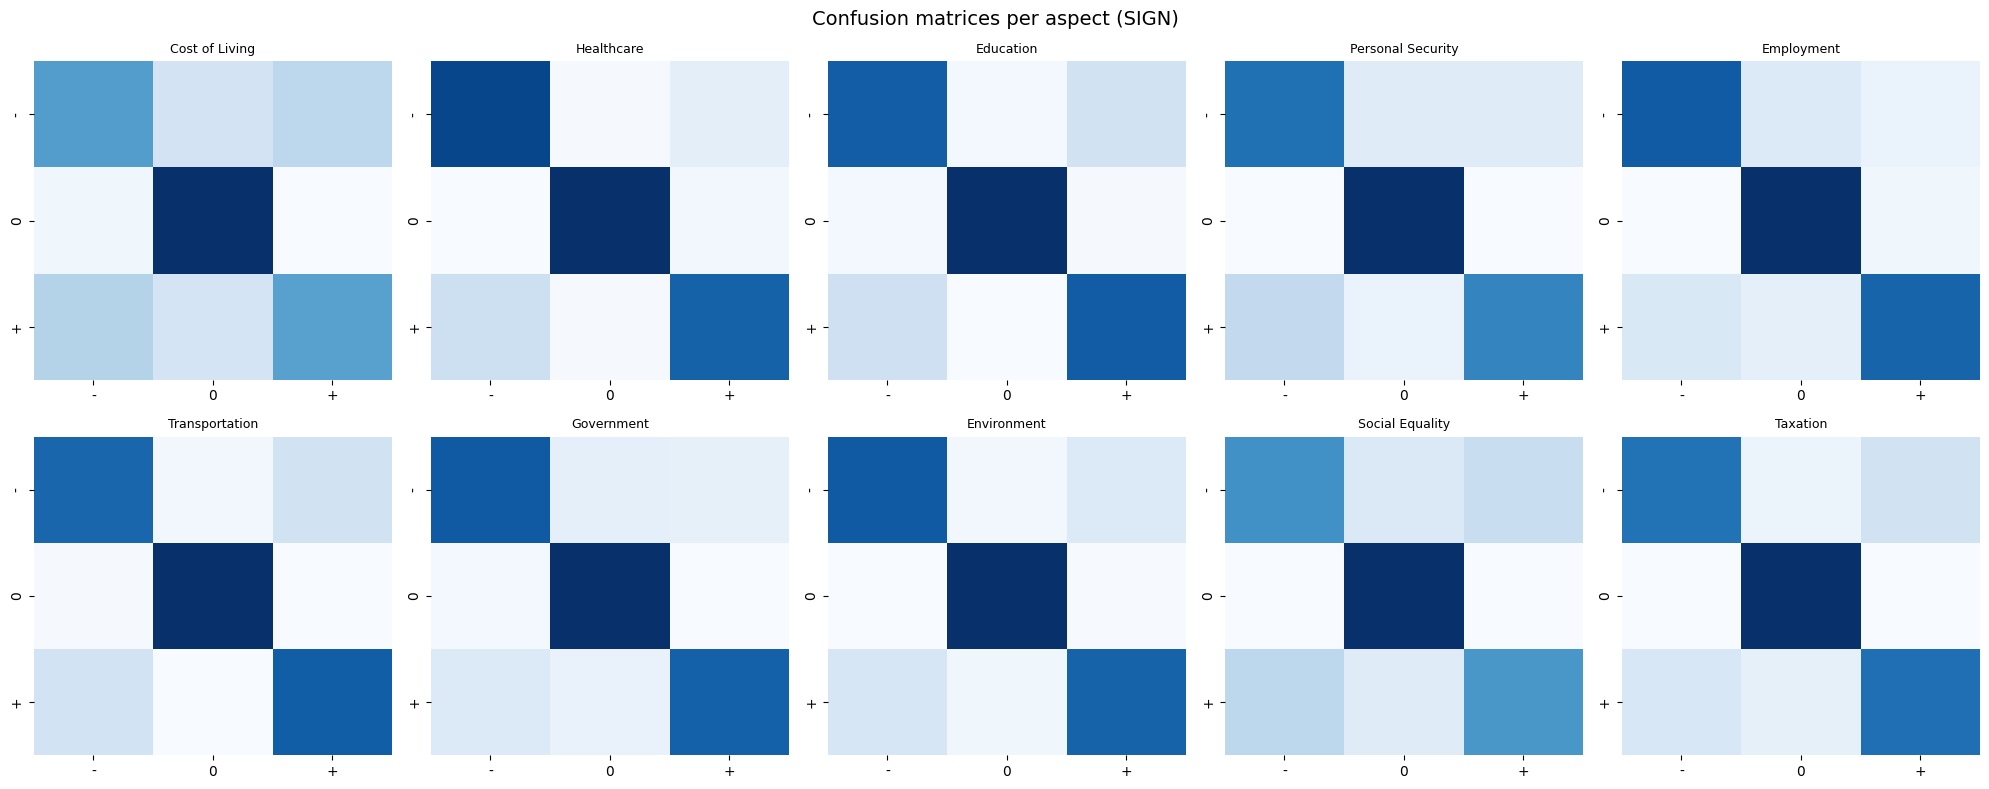

In [7]:
n = len(ASPECTS)
cols = 5
rows = int(np.ceil(n / cols))

plt.figure(figsize=(4*cols, 4*rows))

for i, asp in enumerate(ASPECTS):
    mask = (all_aspects == asp)
    y_true = all_labels[mask]
    y_pred = all_preds[mask]
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2], normalize="true")

    ax = plt.subplot(rows, cols, i+1)
    sns.heatmap(cm, annot=False, cmap="Blues",
                cbar=False,
                xticklabels=["-", "0", "+"],
                yticklabels=["-", "0", "+"])
    ax.set_title(asp, fontsize=9)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Confusion matrices per aspect (SIGN)", fontsize=14)
plt.tight_layout()
plt.show()


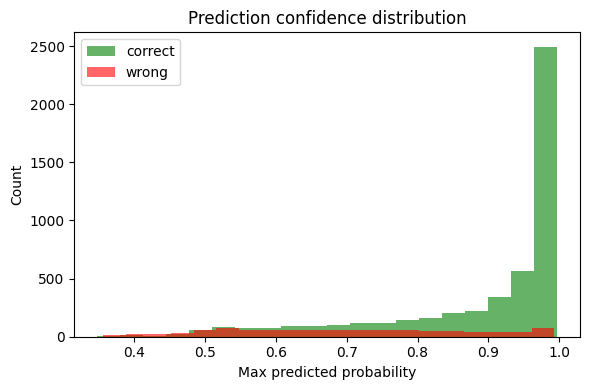

In [ ]:
import matplotlib.pyplot as plt

probs = torch.softmax(torch.tensor(all_logits), dim=-1).numpy()
max_probs = probs.max(axis=-1)        
correct = (all_preds == all_labels)   

plt.figure(figsize=(6,4))
plt.hist(max_probs[correct], bins=20, alpha=0.6, label="correct", color="green")
plt.hist(max_probs[~correct], bins=20, alpha=0.6, label="wrong", color="red")
plt.xlabel("Max predicted probability")
plt.ylabel("Count")
plt.title("Prediction confidence distribution")
plt.legend()
plt.tight_layout()
plt.show()


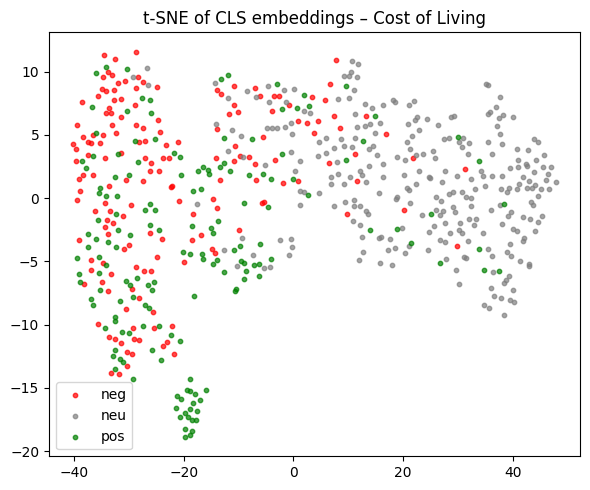

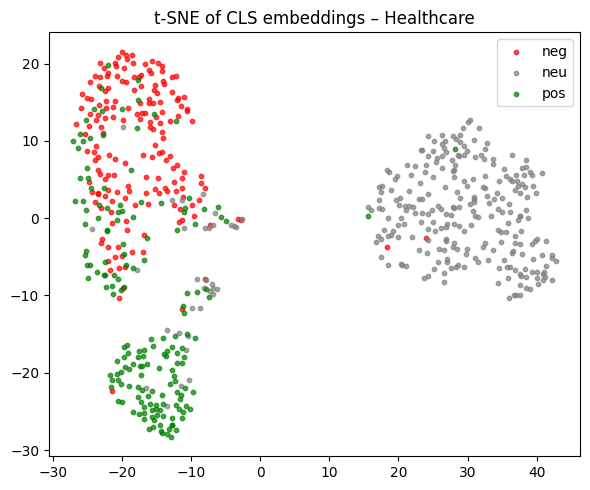

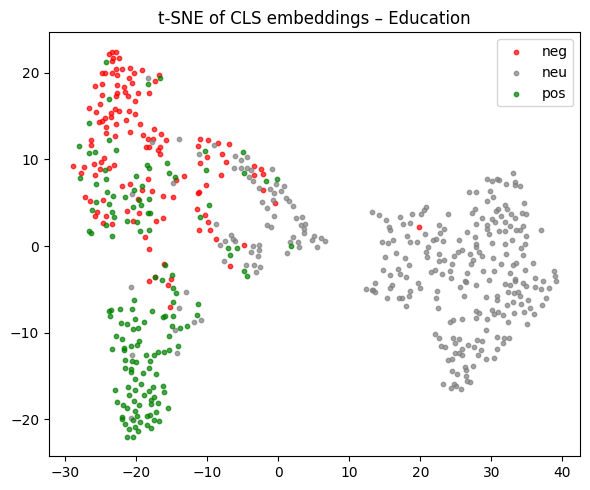

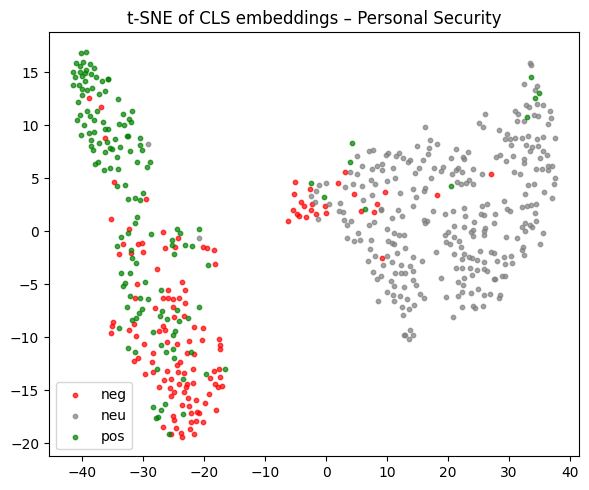

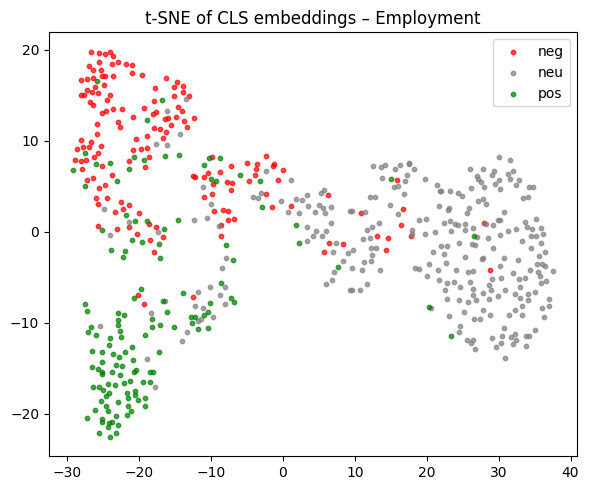

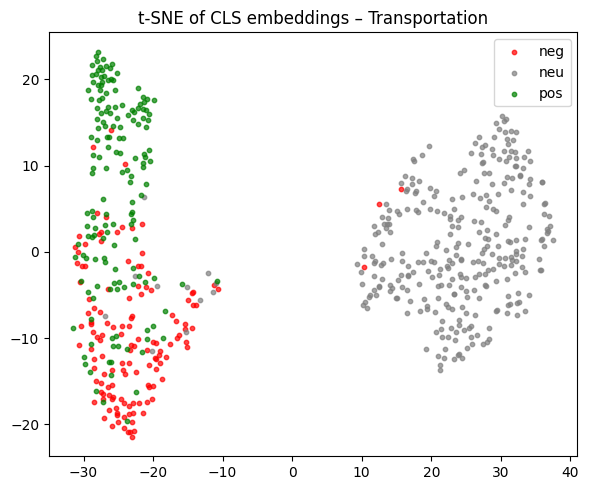

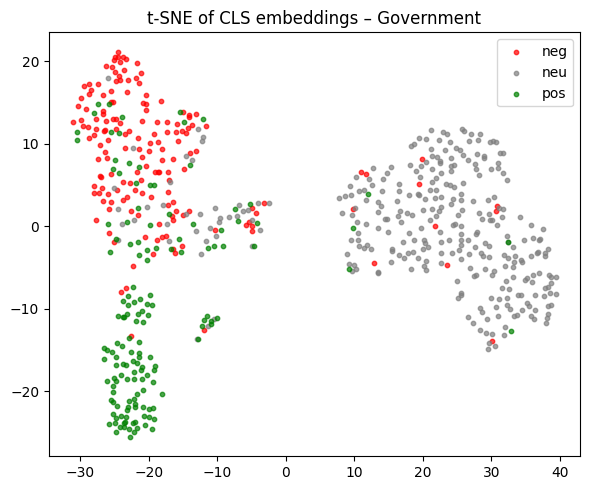

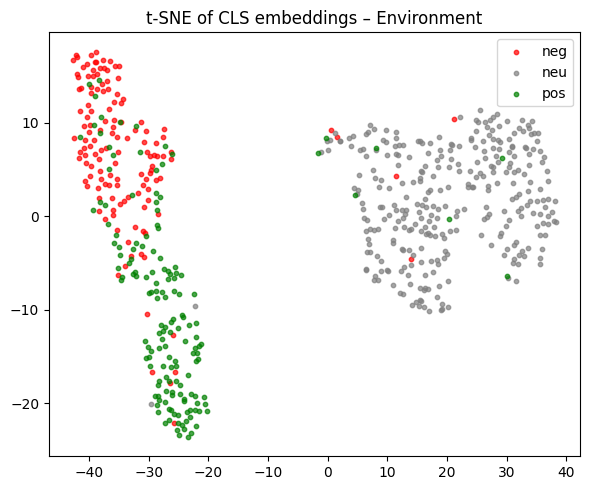

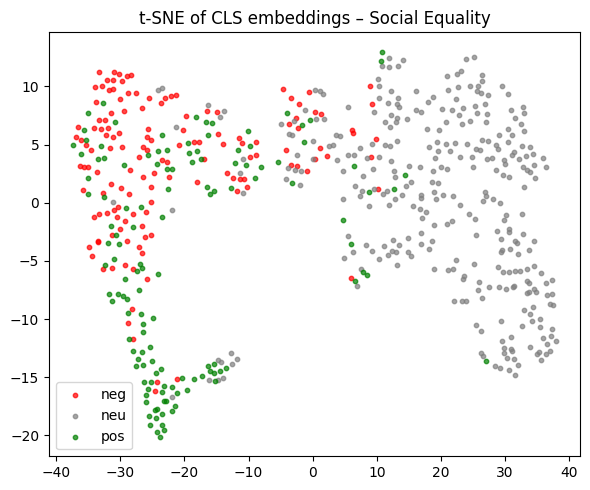

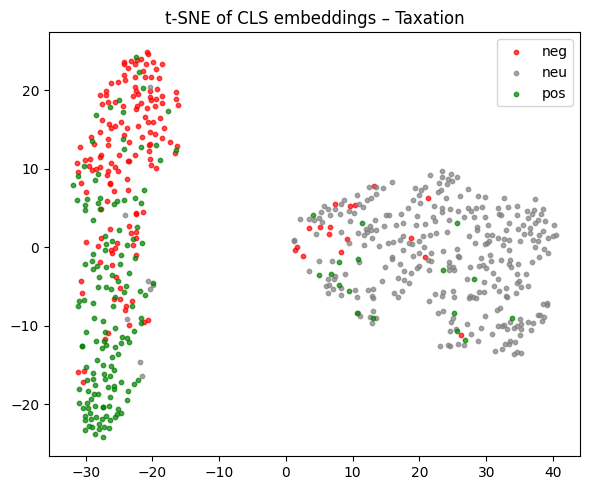

In [ ]:
from sklearn.manifold import TSNE

for aspect in ASPECTS:
    mask = (all_aspects == aspect)
    idxs = np.where(mask)[0]

    idxs = idxs[:1000]

    cls_vectors = []
    labels_tsne = []

    for i in idxs:
        item = test_ds[i]
        inputs = {
            "input_ids": torch.tensor(item["input_ids"]).unsqueeze(0).to(device),
            "attention_mask": torch.tensor(item["attention_mask"]).unsqueeze(0).to(device),
        }
        with torch.no_grad():
            outputs = model.base_model(**inputs)
            cls = outputs.last_hidden_state[:,0,:].cpu().numpy()[0]

        cls_vectors.append(cls)
        labels_tsne.append(item["label"])

    cls_vectors = np.stack(cls_vectors)
    labels_tsne = np.array(labels_tsne)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    emb_2d = tsne.fit_transform(cls_vectors)

    plt.figure(figsize=(6,5))
    for lab, color, name in [(0, "red", "neg"), (1, "gray", "neu"), (2, "green", "pos")]:
        mask_lab = (labels_tsne == lab)
        plt.scatter(emb_2d[mask_lab,0], emb_2d[mask_lab,1],
                    s=10, alpha=0.7, label=name, c=color)

    plt.title(f"t-SNE of CLS embeddings – {aspect}")
    plt.legend()
    plt.tight_layout()
    plt.show()


y_true shape: (1500,)
probs shape : (1500, 3)


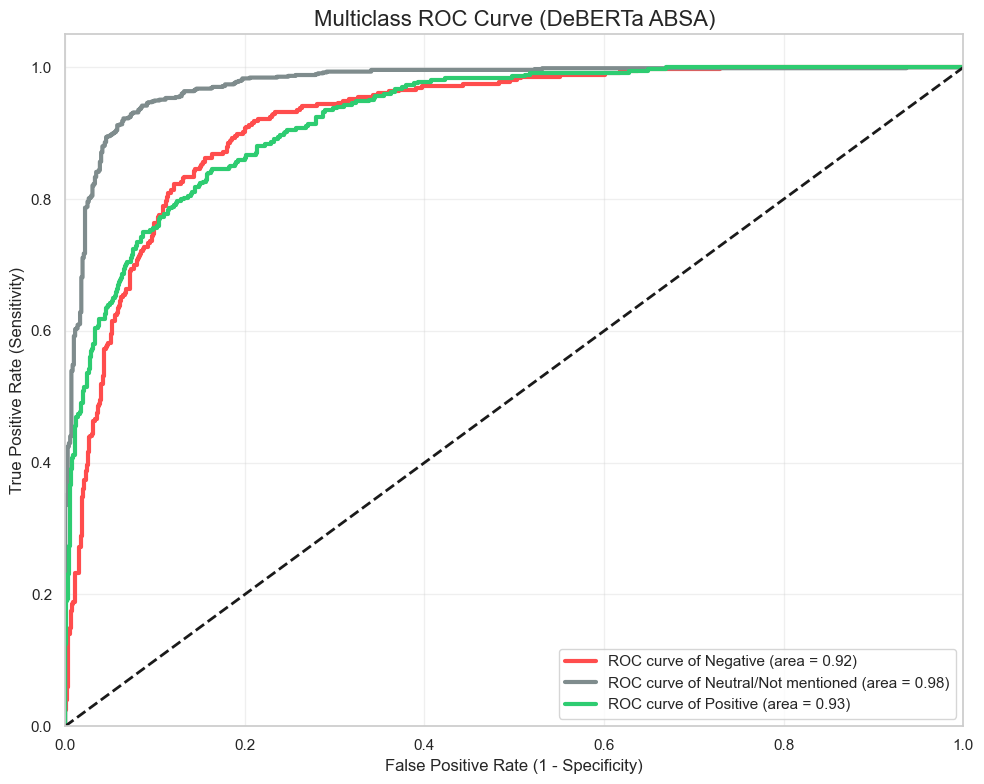

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader

subset_size = 1500
full_test = tokenized_datasets["test"]
subset_size = min(subset_size, len(full_test))

test_subset = full_test.select(range(subset_size)).with_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"],
    output_all_columns=False, 
)

device = model.device
model.eval()

loader = DataLoader(test_subset, batch_size=32)

all_labels = []
all_probs = []

for batch in loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels_batch = batch["label"].numpy()

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs_batch = torch.softmax(logits, dim=-1).cpu().numpy()

    all_labels.append(labels_batch)
    all_probs.append(probs_batch)

y_true = np.concatenate(all_labels, axis=0)  
probs  = np.concatenate(all_probs, axis=0)  

print("y_true shape:", y_true.shape)
print("probs shape :", probs.shape)

y_test_bin = label_binarize(y_true, classes=[0, 1, 2])  
n_classes = y_test_bin.shape[1]

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['#ff4d4d', '#7f8c8d', '#2ecc71']  
class_names = ['Negative', 'Neutral/Not mentioned', 'Positive']

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=3,
        label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Multiclass ROC Curve (DeBERTa ABSA)', fontsize=16)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Running DeBERTa predictions on test set...



=== DeBERTa: classification report ===
                   precision    recall  f1-score   support

     Negative (0)       0.73      0.73      0.73      1504
Not Mentioned (1)       0.91      0.94      0.93      2977
     Positive (2)       0.76      0.71      0.74      1520

         accuracy                           0.83      6001
        macro avg       0.80      0.80      0.80      6001
     weighted avg       0.83      0.83      0.83      6001



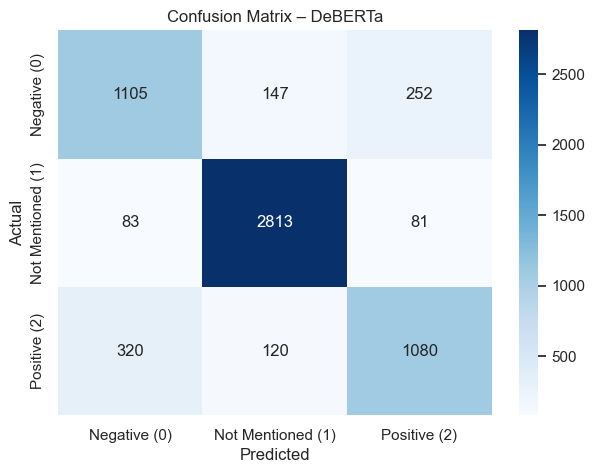

In [31]:
import numpy as np
from transformers import Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# тут model и tokenized_datasets уже должны быть объявлены
training_args = TrainingArguments(
    output_dir="./temp_results_deberta",
    per_device_eval_batch_size=16,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args
)

print("Running DeBERTa predictions on test set...")
predictions_output = trainer.predict(tokenized_datasets["test"])

deberta_preds = np.argmax(predictions_output.predictions, axis=-1)
deberta_labels = predictions_output.label_ids

target_names = ["Negative (0)", "Not Mentioned (1)", "Positive (2)"]

print("\n=== DeBERTa: classification report ===")
print(classification_report(deberta_labels, deberta_preds, target_names=target_names))

cm_deberta = confusion_matrix(deberta_labels, deberta_preds)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_deberta, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – DeBERTa')
plt.show()


Running DeBERTa predictions on test set...



=== DeBERTa: classification report ===
                   precision    recall  f1-score   support

     Negative (0)       0.73      0.73      0.73      1504
Not Mentioned (1)       0.91      0.94      0.93      2977
     Positive (2)       0.76      0.71      0.74      1520

         accuracy                           0.83      6001
        macro avg       0.80      0.80      0.80      6001
     weighted avg       0.83      0.83      0.83      6001



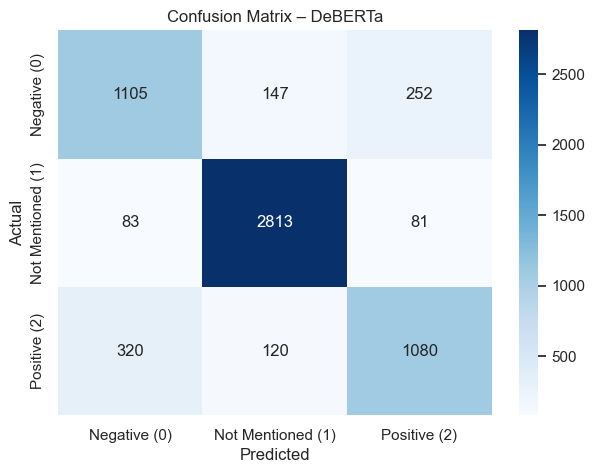

In [32]:
import numpy as np
from transformers import Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# тут model и tokenized_datasets уже должны быть объявлены
training_args = TrainingArguments(
    output_dir="./temp_results_deberta",
    per_device_eval_batch_size=16,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args
)

print("Running DeBERTa predictions on test set...")
predictions_output = trainer.predict(tokenized_datasets["test"])

deberta_preds = np.argmax(predictions_output.predictions, axis=-1)
deberta_labels = predictions_output.label_ids

target_names = ["Negative (0)", "Not Mentioned (1)", "Positive (2)"]

print("\n=== DeBERTa: classification report ===")
print(classification_report(deberta_labels, deberta_preds, target_names=target_names))

cm_deberta = confusion_matrix(deberta_labels, deberta_preds)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_deberta, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – DeBERTa')
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

GEMMA_MODEL = "gemma3"   # или точное имя твоей модели в Ollama

test_raw = dataset_dict["test"]   # HF Dataset с полями text, aspect, label

y_true = np.array(test_raw["label"])
y_pred_gemma = []

print("Running Gemma3 on test set (это может быть долго)...")

for i in tqdm(range(len(test_raw))):
    text = test_raw[i]["text"]
    aspect = test_raw[i]["aspect"]

    prompt = build_gemma_prompt(text, aspect)

    try:
        resp = ollama.chat(
            model=GEMMA_MODEL,
            messages=[{"role": "user", "content": prompt}],
            format="json",
            keep_alive=-1
        )
        content = resp["message"]["content"].strip()
        obj = json.loads(content)
        v = parse_label_from_gemma(obj.get("label", 1))
    except Exception:
        v = 1  # в случае ошибки считаем нейтральным / не упомянутым

    y_pred_gemma.append(v)

y_pred_gemma = np.array(y_pred_gemma)


Running Gemma3 on test set (это может быть долго)...


  1%|          | 42/6001 [00:31<1:12:26,  1.37it/s]

In [ ]:
print("\n=== Gemma3: classification report ===")
print(classification_report(y_true, y_pred_gemma, target_names=target_names))

cm_gemma = confusion_matrix(y_true, y_pred_gemma)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_gemma, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Gemma3')
plt.show()
